# CrowdCast Engine: Spatiotemporal Crowd Prediction Model

---

## Overview

**CrowdCast** predicts crowd density (0-100%) at Sri Lankan tourism locations.

### Features
| Feature | Description |
|---------|-------------|
| `month` | 1-12 (Seasonality) |
| `day_of_week` | 0-6 (Weekend effect) |
| `hour` | 0-23 (Time of day) |
| `is_poya_holiday` | Poya day (0/1) |
| `is_school_holiday` | School break (0/1) |
| `google_trend_30d` | Search interest (0-100) |
| `loc_type` | Heritage/Beach/Nature/Religious/Urban |

**Target:** `crowd_level` (0.0 - 1.0)

---

## 1. Setup & Configuration

In [9]:
# =============================================================================
# INSTALL REQUIRED PACKAGES
# =============================================================================

!pip install -q gdown xgboost pytrends

In [10]:
# =============================================================================
# CONFIGURE PATHS (Works in VS Code Colab Extension & Local)
# =============================================================================

import os

# Set project paths (local directories)
BASE_PATH = os.getcwd()
DATA_PATH = os.path.join(BASE_PATH, 'data')
MODEL_PATH = os.path.join(BASE_PATH, 'models')

# Create directories
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

print(f"Base Path: {BASE_PATH}")
print(f"Data Path: {DATA_PATH}")
print(f"Model Path: {MODEL_PATH}")

Base Path: /content
Data Path: /content/data
Model Path: /content/models


In [11]:
# =============================================================================
# IMPORTS
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import json
import joblib
import warnings
from datetime import datetime, timedelta

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 50)

print("All imports successful!")

All imports successful!


## 2. Load Dataset from Google Drive

In [12]:
# =============================================================================
# DOWNLOAD AND LOAD DATASET FROM GOOGLE DRIVE
# =============================================================================

import gdown

# Replace with your Google Drive file ID
# To get file ID: Right-click file in Drive > Get Link > Copy ID from URL
# Example URL: https://drive.google.com/file/d/1ABC123xyz/view
# File ID would be: 1ABC123xyz

DATASET_FILE_ID = '1z24c237pSvyjFGIbvrFVIHWRKuUqIky2'  # <-- Replace with your file ID

dataset_path = os.path.join(DATA_PATH, 'crowdcast_dataset.csv')

# Download if file ID is provided
if DATASET_FILE_ID != '1z24c237pSvyjFGIbvrFVIHWRKuUqIky2':
    url = f'https://drive.google.com/uc?id={DATASET_FILE_ID}'
    print(f"Downloading dataset from Google Drive...")
    gdown.download(url, output=dataset_path, quiet=False)
    print(f"Downloaded to: {dataset_path}")

# Load dataset into DataFrame
df = pd.read_csv(dataset_path)
print(f"\nDataset loaded successfully!")
print(f"Shape: {df.shape}")
df.head()


Dataset loaded successfully!
Shape: (3505920, 13)


,crowd_level,month,day_of_week,hour,is_weekend,is_poya_holiday,is_school_holiday,google_trend_30d,location,loc_type,date,sltda_factor,hourly_baseline
0,0.022,1,4,0,0,0,0,0.0,Pigeon Island,Beach,2021-01-01,1.3,5.0
1,0.043,1,4,0,0,0,0,0.0,Royal Botanical Gardens,Nature,2021-01-01,1.3,10.0
2,0.043,1,4,0,0,0,0,0.0,Hanthana Mountain Range,Nature,2021-01-01,1.3,10.0
3,0.022,1,4,0,0,0,0,0.0,Weligama Surf Break,Beach,2021-01-01,1.3,5.0
4,0.043,1,4,0,0,0,0,0.0,Ravana Falls,Nature,2021-01-01,1.3,10.0


## 3. Exploratory Data Analysis

In [13]:
# =============================================================================
# DATASET OVERVIEW
# =============================================================================

print("DATASET STATISTICS")
print("=" * 50)
print(f"Total samples: {len(df):,}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Locations: {df['location'].nunique()}")
print(f"Location types: {df['loc_type'].unique().tolist()}")
print(f"\nTarget (crowd_level) stats:")
print(df['crowd_level'].describe())

DATASET STATISTICS
Total samples: 3,505,920
Date range: 2021-01-01 to 2025-12-31
Locations: 80
Location types: ['Beach', 'Nature', 'Heritage', 'Religious', 'Urban']

Target (crowd_level) stats:
count    3.505920e+06
mean     1.098410e-01
std      1.050570e-01
min      5.000000e-03
25%      2.100000e-02
50%      8.200000e-02
75%      1.670000e-01
max      1.000000e+00
Name: crowd_level, dtype: float64


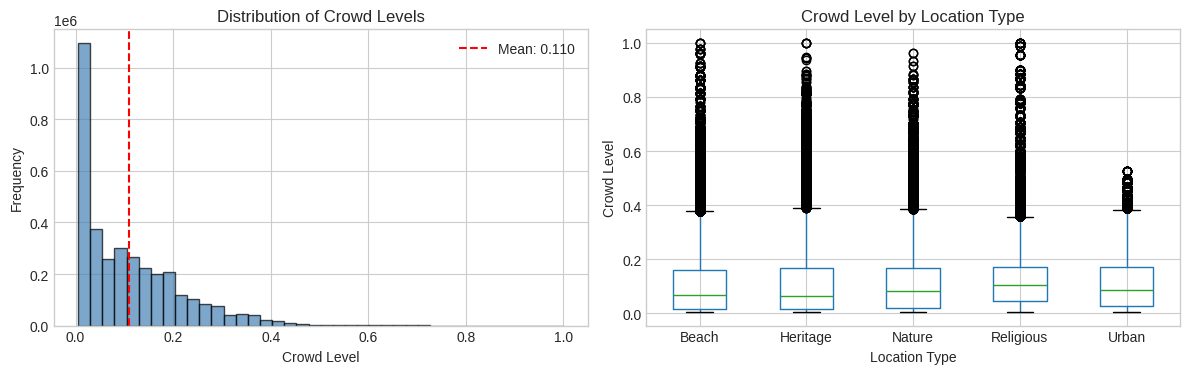

In [14]:
# =============================================================================
# VISUALIZATION: TARGET DISTRIBUTION
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(df['crowd_level'], bins=40, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df['crowd_level'].mean(), color='red', linestyle='--', label=f'Mean: {df["crowd_level"].mean():.3f}')
axes[0].set_xlabel('Crowd Level')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Crowd Levels')
axes[0].legend()

# Box plot by type
df.boxplot(column='crowd_level', by='loc_type', ax=axes[1])
axes[1].set_xlabel('Location Type')
axes[1].set_ylabel('Crowd Level')
axes[1].set_title('Crowd Level by Location Type')
plt.suptitle('')

plt.tight_layout()
plt.savefig(os.path.join(DATA_PATH, 'viz_target_distribution.png'), dpi=150)
plt.show()

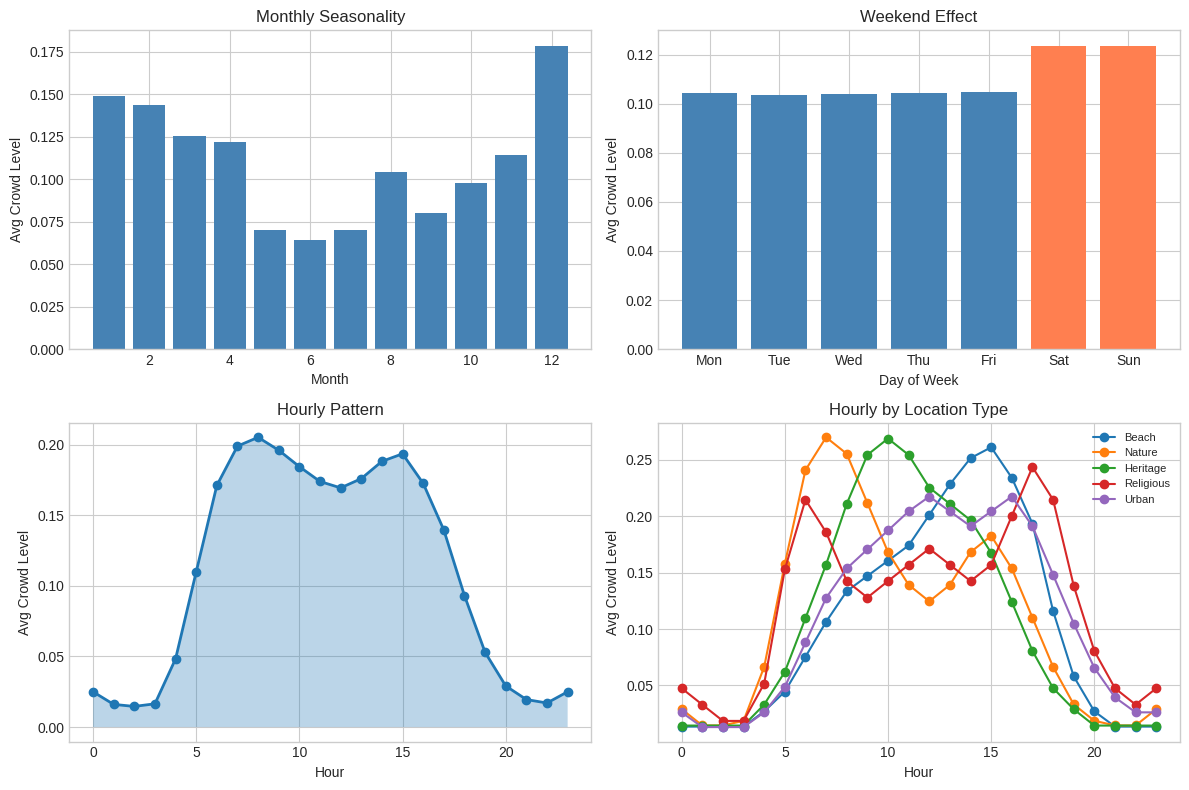

In [15]:
# =============================================================================
# VISUALIZATION: TEMPORAL PATTERNS
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Monthly pattern
monthly = df.groupby('month')['crowd_level'].mean()
axes[0, 0].bar(monthly.index, monthly.values, color='steelblue')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Avg Crowd Level')
axes[0, 0].set_title('Monthly Seasonality')

# Day of week
dow = df.groupby('day_of_week')['crowd_level'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
colors = ['steelblue']*5 + ['coral']*2
axes[0, 1].bar(range(7), dow.values, color=colors)
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(days)
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Avg Crowd Level')
axes[0, 1].set_title('Weekend Effect')

# Hourly pattern
hourly = df.groupby('hour')['crowd_level'].mean()
axes[1, 0].plot(hourly.index, hourly.values, marker='o', linewidth=2)
axes[1, 0].fill_between(hourly.index, hourly.values, alpha=0.3)
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Avg Crowd Level')
axes[1, 0].set_title('Hourly Pattern')

# Hourly by location type
for loc_type in df['loc_type'].unique():
    hourly_type = df[df['loc_type'] == loc_type].groupby('hour')['crowd_level'].mean()
    axes[1, 1].plot(hourly_type.index, hourly_type.values, marker='o', label=loc_type)
axes[1, 1].set_xlabel('Hour')
axes[1, 1].set_ylabel('Avg Crowd Level')
axes[1, 1].set_title('Hourly by Location Type')
axes[1, 1].legend(fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(DATA_PATH, 'viz_temporal_patterns.png'), dpi=150)
plt.show()

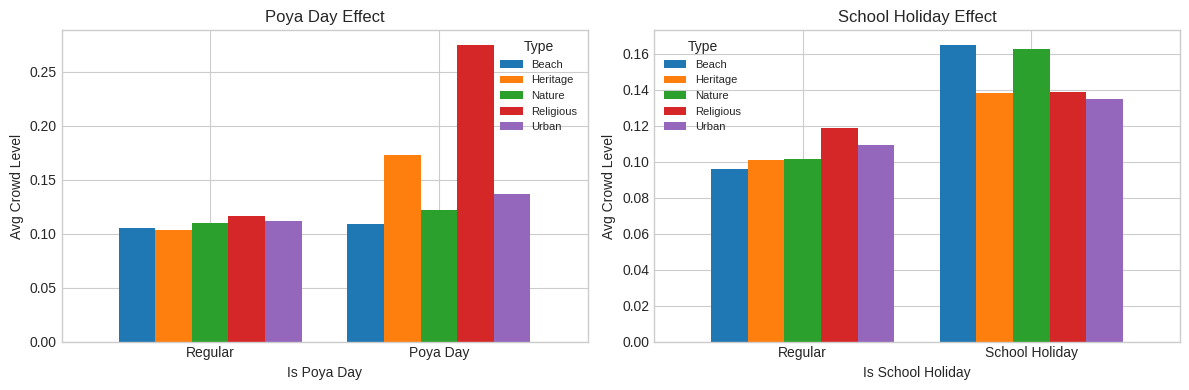

In [16]:
# =============================================================================
# VISUALIZATION: HOLIDAY EFFECTS
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Poya effect
poya_effect = df.groupby(['is_poya_holiday', 'loc_type'])['crowd_level'].mean().unstack()
poya_effect.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_xlabel('Is Poya Day')
axes[0].set_ylabel('Avg Crowd Level')
axes[0].set_title('Poya Day Effect')
axes[0].set_xticklabels(['Regular', 'Poya Day'], rotation=0)
axes[0].legend(title='Type', fontsize=8)

# School holiday effect
school_effect = df.groupby(['is_school_holiday', 'loc_type'])['crowd_level'].mean().unstack()
school_effect.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_xlabel('Is School Holiday')
axes[1].set_ylabel('Avg Crowd Level')
axes[1].set_title('School Holiday Effect')
axes[1].set_xticklabels(['Regular', 'School Holiday'], rotation=0)
axes[1].legend(title='Type', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(DATA_PATH, 'viz_holiday_effects.png'), dpi=150)
plt.show()

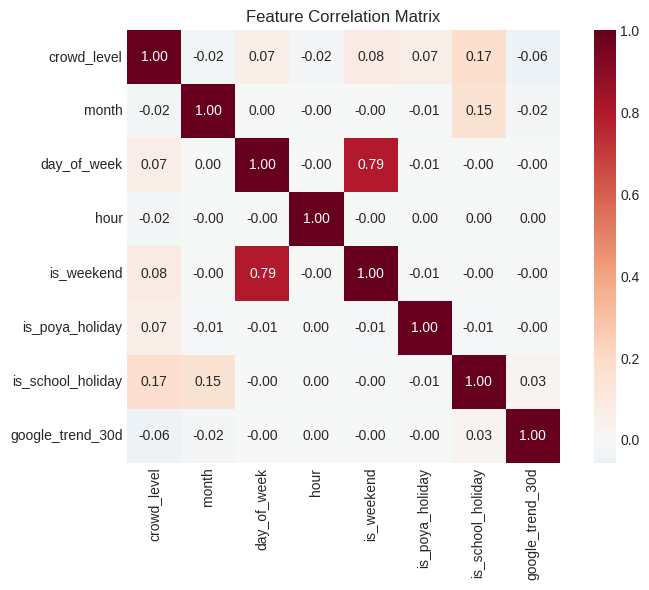


Correlations with crowd_level:
crowd_level          1.000000
is_school_holiday    0.171052
is_weekend           0.082709
day_of_week          0.066304
is_poya_holiday      0.065923
hour                -0.015931
month               -0.023526
google_trend_30d    -0.055428
Name: crowd_level, dtype: float64


In [17]:
# =============================================================================
# VISUALIZATION: CORRELATION HEATMAP
# =============================================================================

numeric_cols = ['crowd_level', 'month', 'day_of_week', 'hour', 
                'is_weekend', 'is_poya_holiday', 'is_school_holiday', 'google_trend_30d']

corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0, square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig(os.path.join(DATA_PATH, 'viz_correlations.png'), dpi=150)
plt.show()

print("\nCorrelations with crowd_level:")
print(corr['crowd_level'].sort_values(ascending=False))

## 4. Data Preprocessing

In [18]:
# =============================================================================
# PREPROCESSING
# =============================================================================

# Encode location type
le = LabelEncoder()
df['loc_type_encoded'] = le.fit_transform(df['loc_type'])

print("Location Type Encoding:")
for i, label in enumerate(le.classes_):
    print(f"  {i}: {label}")

# Define features
FEATURES = [
    'month',
    'day_of_week',
    'hour',
    'is_poya_holiday',
    'is_school_holiday',
    'google_trend_30d',
    'loc_type_encoded'
]

TARGET = 'crowd_level'

# Split data
X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTrain set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")

Location Type Encoding:
  0: Beach
  1: Heritage
  2: Nature
  3: Religious
  4: Urban

Train set: 2,804,736 samples
Test set: 701,184 samples


## 5. Model Training

In [19]:
# =============================================================================
# TRAIN RANDOM FOREST
# =============================================================================

print("Training Random Forest...")

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Evaluate
y_pred_rf = rf.predict(X_test)

rf_r2 = r2_score(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_mae = mean_absolute_error(y_test, y_pred_rf)

print(f"\nRandom Forest Results:")
print(f"  R2 Score: {rf_r2:.4f}")
print(f"  RMSE: {rf_rmse:.4f}")
print(f"  MAE: {rf_mae:.4f}")

Training Random Forest...

Random Forest Results:
  R2 Score: 0.9675
  RMSE: 0.0190
  MAE: 0.0094


In [20]:
# =============================================================================
# TRAIN XGBOOST
# =============================================================================

print("Training XGBoost...")

xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Evaluate
y_pred_xgb = xgb_model.predict(X_test)

xgb_r2 = r2_score(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)

print(f"\nXGBoost Results:")
print(f"  R2 Score: {xgb_r2:.4f}")
print(f"  RMSE: {xgb_rmse:.4f}")
print(f"  MAE: {xgb_mae:.4f}")

Training XGBoost...

XGBoost Results:
  R2 Score: 0.9982
  RMSE: 0.0044
  MAE: 0.0023


In [21]:
# =============================================================================
# MODEL COMPARISON
# =============================================================================

comparison = pd.DataFrame({
    'Metric': ['R2 Score', 'RMSE', 'MAE'],
    'Random Forest': [rf_r2, rf_rmse, rf_mae],
    'XGBoost': [xgb_r2, xgb_rmse, xgb_mae]
})

print("\nMODEL COMPARISON")
print("=" * 50)
print(comparison.to_string(index=False))

# Select best model
best_model = xgb_model if xgb_r2 > rf_r2 else rf
best_name = 'XGBoost' if xgb_r2 > rf_r2 else 'Random Forest'
best_pred = y_pred_xgb if xgb_r2 > rf_r2 else y_pred_rf

print(f"\nBest Model: {best_name}")


MODEL COMPARISON
  Metric  Random Forest  XGBoost
R2 Score       0.967457 0.998209
    RMSE       0.018966 0.004449
     MAE       0.009414 0.002338

Best Model: XGBoost


## 6. Model Evaluation

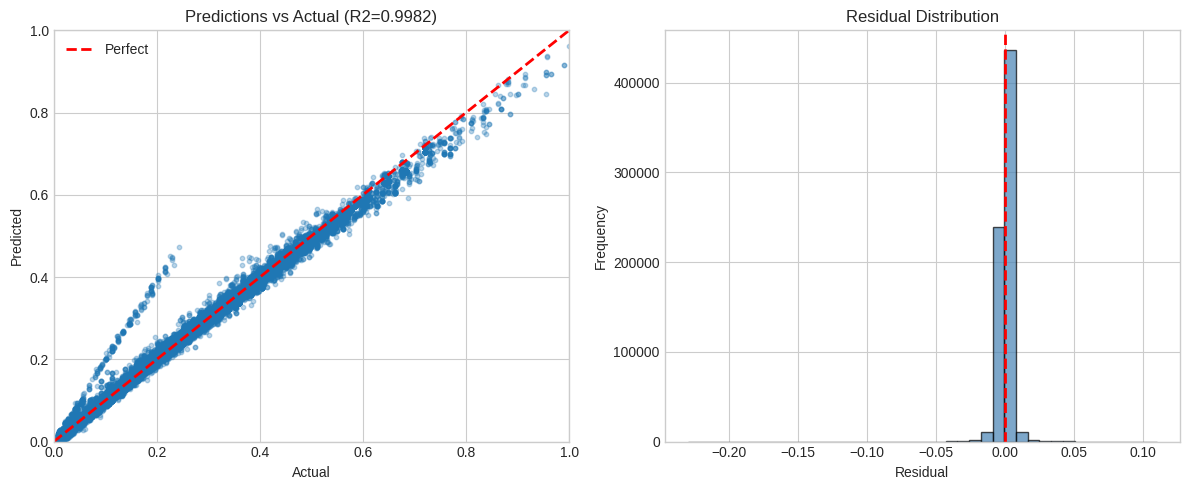

In [22]:
# =============================================================================
# VISUALIZATION: PREDICTIONS VS ACTUAL
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot
axes[0].scatter(y_test, best_pred, alpha=0.3, s=10)
axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title(f'Predictions vs Actual (R2={max(rf_r2, xgb_r2):.4f})')
axes[0].legend()
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)

# Residuals
residuals = y_test - best_pred
axes[1].hist(residuals, bins=40, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')

plt.tight_layout()
plt.savefig(os.path.join(DATA_PATH, 'viz_model_evaluation.png'), dpi=150)
plt.show()

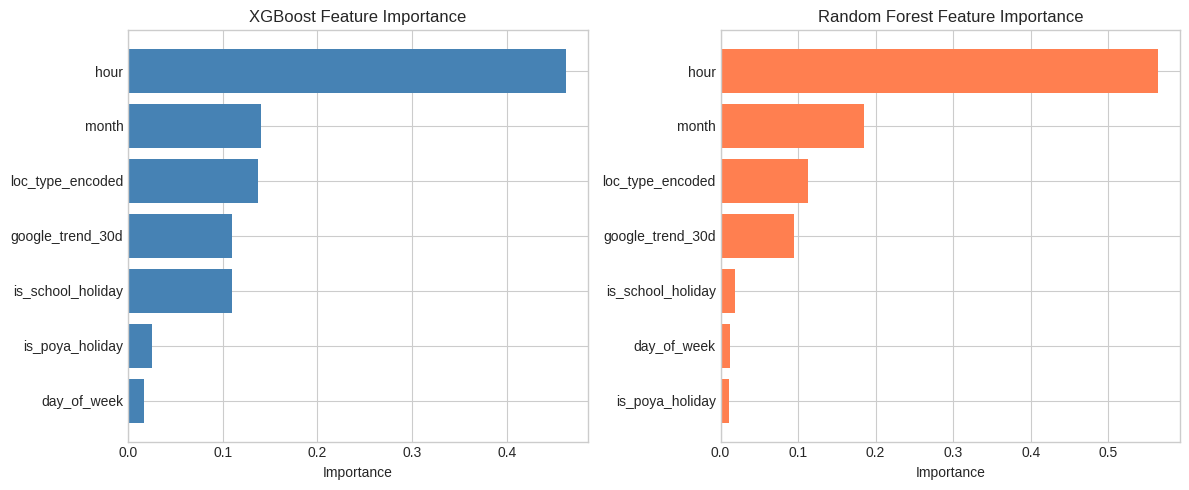

In [23]:
# =============================================================================
# VISUALIZATION: FEATURE IMPORTANCE
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# XGBoost importance
xgb_imp = pd.DataFrame({'Feature': FEATURES, 'Importance': xgb_model.feature_importances_})
xgb_imp = xgb_imp.sort_values('Importance', ascending=True)
axes[0].barh(xgb_imp['Feature'], xgb_imp['Importance'], color='steelblue')
axes[0].set_xlabel('Importance')
axes[0].set_title('XGBoost Feature Importance')

# Random Forest importance
rf_imp = pd.DataFrame({'Feature': FEATURES, 'Importance': rf.feature_importances_})
rf_imp = rf_imp.sort_values('Importance', ascending=True)
axes[1].barh(rf_imp['Feature'], rf_imp['Importance'], color='coral')
axes[1].set_xlabel('Importance')
axes[1].set_title('Random Forest Feature Importance')

plt.tight_layout()
plt.savefig(os.path.join(DATA_PATH, 'viz_feature_importance.png'), dpi=150)
plt.show()

## 7. Save Model Locally

Models are saved locally. To upload to Google Drive, use `gdown` upload or manually upload the files.

In [24]:
# =============================================================================
# SAVE MODEL & ARTIFACTS LOCALLY
# =============================================================================

print("Saving model and artifacts...")

# 1. Save XGBoost model (JSON format)
model_json_path = os.path.join(MODEL_PATH, 'crowdcast_model.json')
xgb_model.save_model(model_json_path)
print(f"  Model (JSON): {model_json_path}")

# 2. Save model as joblib
model_joblib_path = os.path.join(MODEL_PATH, 'crowdcast_model.joblib')
joblib.dump(xgb_model, model_joblib_path)
print(f"  Model (Joblib): {model_joblib_path}")

# 3. Save label encoder
encoder_path = os.path.join(MODEL_PATH, 'label_encoder.joblib')
joblib.dump(le, encoder_path)
print(f"  Encoder: {encoder_path}")

# 4. Save metadata
metadata = {
    'model_name': 'CrowdCast Engine',
    'version': '1.0.0',
    'created_at': datetime.now().isoformat(),
    'features': FEATURES,
    'target': TARGET,
    'performance': {
        'r2_score': float(xgb_r2),
        'rmse': float(xgb_rmse),
        'mae': float(xgb_mae)
    },
    'location_types': le.classes_.tolist(),
    'train_samples': len(X_train),
    'test_samples': len(X_test)
}

metadata_path = os.path.join(MODEL_PATH, 'metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"  Metadata: {metadata_path}")

print("\nAll files saved locally!")
print(f"\nTo upload to Google Drive, copy files from:")
print(f"  {MODEL_PATH}")

Saving model and artifacts...
  Model (JSON): /content/models/crowdcast_model.json
  Model (Joblib): /content/models/crowdcast_model.joblib
  Encoder: /content/models/label_encoder.joblib
  Metadata: /content/models/metadata.json

All files saved locally!

To upload to Google Drive, copy files from:
  /content/models


In [25]:
# =============================================================================
# OPTIONAL: UPLOAD TO GOOGLE DRIVE (Uncomment to use)
# =============================================================================

# Method 1: Using PyDrive2 (requires authentication)
# !pip install -q pydrive2

# from pydrive2.auth import GoogleAuth
# from pydrive2.drive import GoogleDrive

# # Authenticate (will open browser for OAuth)
# gauth = GoogleAuth()
# gauth.LocalWebserverAuth()
# drive = GoogleDrive(gauth)

# # Upload model file
# file = drive.CreateFile({'title': 'crowdcast_model.json'})
# file.SetContentFile(os.path.join(MODEL_PATH, 'crowdcast_model.json'))
# file.Upload()
# print(f"Uploaded: {file['title']} (ID: {file['id']})")

# Method 2: Manual upload
print("To upload to Google Drive manually:")
print("1. Go to https://drive.google.com")
print("2. Create folder: CrowdCast/models")
print("3. Upload files from local paths shown above")
print("")
print("Files to upload:")
for f in ['crowdcast_model.json', 'crowdcast_model.joblib', 'label_encoder.joblib', 'metadata.json']:
    print(f"  - {f}")

To upload to Google Drive manually:
1. Go to https://drive.google.com
2. Create folder: CrowdCast/models
3. Upload files from local paths shown above

Files to upload:
  - crowdcast_model.json
  - crowdcast_model.joblib
  - label_encoder.joblib
  - metadata.json


## 8. Inference Example

In [26]:
# =============================================================================
# PREDICTION FUNCTION
# =============================================================================

def predict_crowd(location_type, month, day_of_week, hour, 
                  is_poya, is_school, google_trend):
    """
    Predict crowd level for a given scenario.
    
    Args:
        location_type: 'Heritage', 'Beach', 'Nature', 'Religious', 'Urban'
        month: 1-12
        day_of_week: 0=Mon, 6=Sun
        hour: 0-23
        is_poya: True/False
        is_school: True/False
        google_trend: 0-100
    
    Returns:
        crowd_level (0-1), interpretation
    """
    # Encode location type
    loc_encoded = le.transform([location_type])[0]
    
    # Create feature array
    X = np.array([[
        month, day_of_week, hour,
        int(is_poya), int(is_school),
        google_trend, loc_encoded
    ]])
    
    # Predict
    crowd = xgb_model.predict(X)[0]
    crowd = np.clip(crowd, 0, 1)
    
    # Interpret
    if crowd >= 0.8:
        status = "EXTREME"
    elif crowd >= 0.6:
        status = "HIGH"
    elif crowd >= 0.4:
        status = "MODERATE"
    elif crowd >= 0.2:
        status = "LOW"
    else:
        status = "MINIMAL"
    
    return crowd, status

In [27]:
# =============================================================================
# TEST PREDICTIONS
# =============================================================================

print("PREDICTION EXAMPLES")
print("=" * 60)

# Scenario 1
crowd, status = predict_crowd('Nature', 12, 5, 10, True, True, 80)
print(f"\n1. Yala on Poya Saturday in December, 10 AM")
print(f"   Crowd: {crowd:.1%} ({status})")

# Scenario 2
crowd, status = predict_crowd('Religious', 6, 1, 9, False, False, 45)
print(f"\n2. Temple on regular Tuesday in June, 9 AM")
print(f"   Crowd: {crowd:.1%} ({status})")

# Scenario 3
crowd, status = predict_crowd('Beach', 8, 6, 16, False, True, 60)
print(f"\n3. Beach on Sunday in August, 4 PM")
print(f"   Crowd: {crowd:.1%} ({status})")

# Scenario 4
crowd, status = predict_crowd('Heritage', 5, 2, 7, False, False, 30)
print(f"\n4. Sigiriya on Wednesday in May, 7 AM")
print(f"   Crowd: {crowd:.1%} ({status})")

PREDICTION EXAMPLES

1. Yala on Poya Saturday in December, 10 AM
   Crowd: 68.5% (HIGH)

2. Temple on regular Tuesday in June, 9 AM
   Crowd: 7.4% (MINIMAL)

3. Beach on Sunday in August, 4 PM
   Crowd: 42.9% (MODERATE)

4. Sigiriya on Wednesday in May, 7 AM
   Crowd: 5.7% (MINIMAL)


## 9. Summary

In [28]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================

print("""
================================================================================
                     CROWDCAST ENGINE: TRAINING COMPLETE
================================================================================

MODEL SUMMARY
-------------
""")
print(f"Model: XGBoost Regressor")
print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")
print(f"Features: {len(FEATURES)}")
print(f"")
print(f"PERFORMANCE")
print(f"-----------")
print(f"R2 Score: {xgb_r2:.4f}")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"MAE: {xgb_mae:.4f}")
print(f"")
print(f"FILES SAVED")
print(f"-----------")
print(f"Model: {os.path.join(MODEL_PATH, 'crowdcast_model.json')}")
print(f"Encoder: {os.path.join(MODEL_PATH, 'label_encoder.joblib')}")
print(f"Metadata: {os.path.join(MODEL_PATH, 'metadata.json')}")
print(f"Dataset: {dataset_path}")
print(f"")
print("CrowdCast Engine is ready for deployment!")


                     CROWDCAST ENGINE: TRAINING COMPLETE

MODEL SUMMARY
-------------

Model: XGBoost Regressor
Training samples: 2,804,736
Test samples: 701,184
Features: 7

PERFORMANCE
-----------
R2 Score: 0.9982
RMSE: 0.0044
MAE: 0.0023

FILES SAVED
-----------
Model: /content/models/crowdcast_model.json
Encoder: /content/models/label_encoder.joblib
Metadata: /content/models/metadata.json
Dataset: /content/data/crowdcast_dataset.csv

CrowdCast Engine is ready for deployment!
